In [134]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

from groove.embedding import bar_embedding_freq, load_bar_embedding_freq,get_freq_segmented_transience, load_bar_embedding_total, bar_embedding_total, smooth_power
from groove.downbeats import get_measures, get_beat_frames, beat_peaks, get_beat_data, get_audio_data
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points, find_closest_indices
import groove


def simulate_num_components(data, num_trials, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False):
    counts = {}
    for _ in range(num_trials):
        n_components = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights).means_.shape[0]
        if n_components in counts:
            counts[n_components] += 1
        else:
            counts[n_components] = 1
    return counts




def do_clustering(data, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False, verbose=False):
    gm = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights, verbose=verbose)
    print(f"Weights: {gm.weights_}")

    pca = PCA(n_components=2)
    pca.fit(data)
    print(f"PCA values: {pca.singular_values_}")

    return gm, pca

def do_projected_plot(gm, pca, data, confidence=0.9, data_list=None, file_list=None):

    red_data = pca.transform(data)
    patches, _ = get_patches(gm, confidence=confidence, pts=data, pca=pca)

    # Get axes min and max
    xlim = np.abs(red_data[:,0]).max() * 1.1
    ylim = np.abs(red_data[:,1]).max() * 1.1

    plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.set_xlim([-xlim, xlim])
    ax.set_ylim([-ylim, ylim])

    if data_list != None:
        cmap = mpl.colormaps['gist_rainbow'](np.linspace(0, 1, len(data_list)))
        #plt.cm.get_cmap('hsv', len(data_list)+1)

        running_total = 0
        legend_patches = []
        for i, d in enumerate(data_list):
            plt.scatter(red_data[running_total:running_total + d.shape[0],0], red_data[running_total:running_total + d.shape[0],1], alpha=0.5, color=cmap[i], s=3)
            running_total += d.shape[0]
            if file_list != None:
                legend_patches.append(mpatches.Patch(color=cmap[i], label=file_list[i][0]))
        if file_list != None:
            ax.legend(handles=legend_patches)
    else:
        plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
    
    for p in patches:
        ax.add_patch(p)

    return patches


from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, beat_peaks
from groove.embedding import smooth_power
import librosa
from typing import Callable

def do_bar_sample(indices, file, process: Callable, ext="mp3"):
    raw_measures, proc_measures, sr = get_measures(file, process, ext)
    plot_bar_sample(indices, raw_measures, proc_measures, sr)
    return raw_measures, proc_measures, sr
def plot_bar_sample(indices, raw_measures, proc_measures, sr, grid=[16], labels=['lo','mid','hi']):
    norms = np.max(np.stack([np.max(proc,axis=0) for proc in procs]), axis=0)
    
    for i in indices:
        raw, proc = raw_measures[i], proc_measures[i]
        #beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
        #clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


        plt.figure(figsize=(20, 4))
        #plt.plot(raw)
        plt.plot(proc/norms,label=labels)
        for div in grid:
          for i in range(div):
            plt.vlines(i*len(proc)/div, 0,1, linestyles='dashed')
        plt.legend()
        #plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
        display(Audio(data=raw, rate=sr))
        #display(Audio(data=raw + clicks, rate=sr))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import groove.embedding

proc_fn = groove.embedding.smooth_power

# divs = np.array([3, 4, 6, 8, 9, 12, 15, 16, 18, 20, 21, 24])
divs = np.array([16])
# wts = 1/np.sqrt(divs)
# wts = 1/np.sqrt(divs)
wts=np.ones_like(divs)


# file_list = ['milaklaw', '06 Encore A', 'lms', ('09 D\'Angelo - Spanish Joint', 'm4a'), ('03 All the Pretty Girls', 'm4a')]
file_list = [ ('06 Encore A','mp3'),  ('09 D\'Angelo - Spanish Joint', 'm4a'), ('03 All the Pretty Girls', 'm4a')]

# Add extension
for i in range(len(file_list)):
    if type(file_list[i]) is not tuple:
        file_list[i] = (file_list[i], "mp3")

data_list = []
file_indices_list = []
indices_list = []
for i, (file, ext) in enumerate(file_list):
    data_list.append(load_bar_embedding_freq(file, divisions=divs, weights=wts, process=get_freq_segmented_transience,kernel_width=30, ext=ext))
    file_indices_list.append(np.full((data_list[i].shape[0],), i))
    indices_list.append(np.arange(data_list[i].shape[0]))

# Data, the index in file_list that the data came from, and the index inside its sublist
data = np.concatenate(data_list, axis=0)
data_file_inds = np.concatenate(file_indices_list, axis=0)
data_inds = np.concatenate(indices_list, axis=0)

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
/Users/duncan/Documents/code/erdos/groove_gang/groove/downbeats.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f'inputs/{file}.{ext}')
/Users/duncan/mambaforge/envs/groove/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Score: 200.2514254682542
Num components: 10
Score: 201.01871248727568
Num components: 10
Score: 200.08824898156425
Num components: 10
Overlaps 0.5103626943005182
Containment [0.02849741 0.24870466 0.62953368 0.02590674 0.33419689 0.19689119
 0.12694301 0.01813472 0.02849741 0.01813472]
Failed because some clusters beneath required coverage 0.09999999999999999.
Score: 199.3241987395387
Num components: 9
Score: 198.43329701455204
Num components: 9
Score: 199.4368748025164
Num components: 9
Overlaps 0.5155440414507773
Containment [0.02072539 0.22279793 0.63989637 0.12694301 0.24870466 0.03626943
 0.33419689 0.02849741 0.01813472]
Failed because some clusters beneath required coverage 0.09999999999999999.
Score: 197.1451239794358
Num components: 8
Score: 197.51498855673952
Num components: 8
Score: 197.5109691279735
Num components: 8
Overlaps 0.47668393782383417
Containment [0.03367876 0.29015544 0.31088083 0.12694301 0.39378238 0.05440415
 0.56994819 0.02331606]
Failed because some cluster

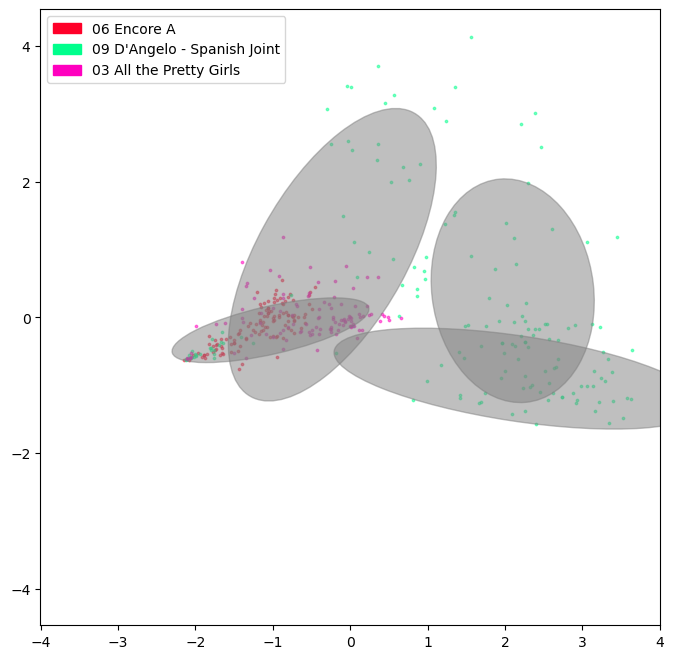

In [15]:
#c = .8
#gm, pca = do_clustering(data, confidence_limit=c, cluster_threshold=0.3, overlap_allowance=0.2, use_weights=False, verbose=True)

c = .8
gm, pca = do_clustering(data, confidence_limit=c, cluster_threshold=0.3/len(file_list), overlap_allowance=1, use_weights=False, verbose=True)

do_projected_plot(gm, pca, data, c, data_list=data_list, file_list=file_list)

Score: 2602.660863194785
Num components: 10
Score: 2617.508709027298
Num components: 10
Score: 2610.700216554258
Num components: 10
Overlaps 0.15025906735751296
Containment [0.03108808 0.06476684 0.08031088 0.19689119 0.16839378 0.13212435
 0.40673575 0.02849741 0.01813472 0.02331606]
Failed because some clusters beneath required coverage 0.09999999999999999.
Score: 2605.7342793137127
Num components: 9
Score: 2599.9722382005084
Num components: 9
Score: 2581.698640157931
Num components: 9
Overlaps 0.19948186528497408
Containment [0.20207254 0.04663212 0.07512953 0.50259067 0.02331606 0.03367876
 0.17875648 0.04145078 0.09585492]
Failed because some clusters beneath required coverage 0.09999999999999999.
Score: 2588.559677235256
Num components: 8
Score: 2592.1864823830238
Num components: 8
Score: 2576.5606075402093
Num components: 8
Overlaps 0.21761658031088082
Containment [0.52849741 0.19170984 0.08031088 0.20466321 0.03367876 0.12953368
 0.02331606 0.02849741]
Failed because some clust

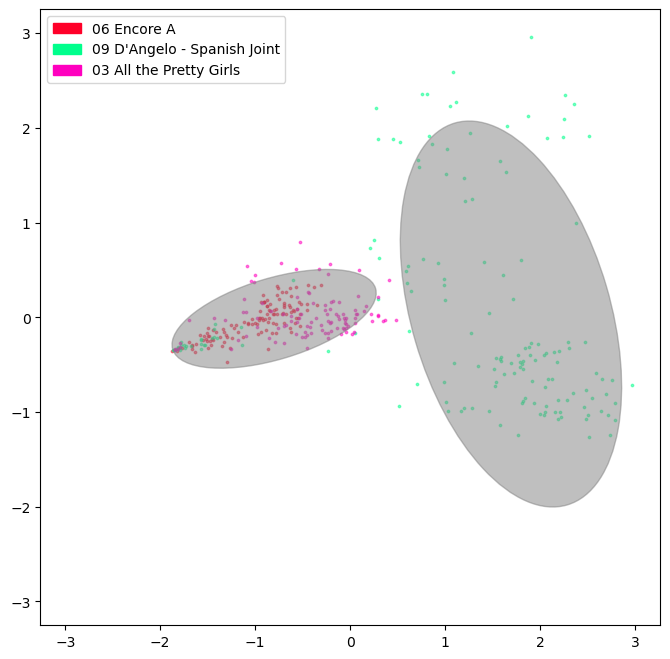

In [ ]:
#c = .8
#gm, pca = do_clustering(data, confidence_limit=c, cluster_threshold=0.3, overlap_allowance=0.2, use_weights=False, verbose=True)

c = .8
gm, pca = do_clustering(data, confidence_limit=c, cluster_threshold=0.3/len(file_list), overlap_allowance=1, use_weights=False, verbose=True)

do_projected_plot(gm, pca, data, c, data_list=data_list, file_list=file_list)

In [28]:
data_list[0]

array([[1.26685453e-01, 3.01173511e-01, 2.40610366e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.76538766e-02, 9.81482559e-02, 2.08851870e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.02807398e-01, 2.33271279e-01, 1.68913577e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.41130834e-03, 1.18200528e-03, 1.42909845e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.54322011e-02, 4.17972165e-02, 4.14627707e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.03652946e-05, 2.14787555e-05, 1.69354986e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [51]:
enc = np.concatenate(data_list[0])

In [49]:
enc.reshape(-1,16,3)

array([[[1.26685453e-01, 3.01173511e-01, 2.40610366e-01],
        [4.93963994e-02, 4.22539595e-02, 1.02245359e-01],
        [9.51637539e-02, 1.40646557e-01, 1.18543358e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[9.76538766e-02, 9.81482559e-02, 2.08851870e-03],
        [1.29994511e-01, 1.79108684e-01, 5.39553398e-02],
        [1.37690898e-01, 1.33127114e-01, 7.76086340e-02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[2.02807398e-01, 2.33271279e-01, 1.68913577e-01],
        [1.18447404e-01, 3.28441918e-01, 3.12142676e-01],
        [1.58470141e-01, 1.21250396e-01, 5.17428242e-02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00

In [39]:
plt.imshow(enc.reshape(3,-1)[:10])

AttributeError: 'numpy.flatiter' object has no attribute 'reshape'

In [66]:
filename='inputs/'+file_list[0][0]
samples,sr= librosa.load('inputs/'+file_list[0][0]+'.'+file_list[0][1])

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


In [55]:
samples

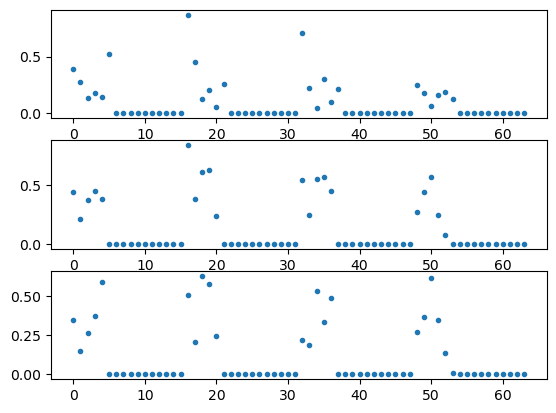

In [65]:
fig, axes = plt.subplots(3,1)
start=16*3*40
end=start+1*64*3
axes[0].plot(enc[start:end:3],linestyle='None',marker='.')
axes[1].plot(enc[start+1:end:3],linestyle='None',marker='.')
axes[2].plot(enc[start+2:end:3],linestyle='None',marker='.')
clipstart = int(len(samples)*start/len(enc))
clipend= int(len(samples)*end/len(enc))
display(Audio(data=samples[clipstart:clipend],rate=sr))

In [62]:
Audio?

Init signature:
Audio(
    data=None,
    filename=None,
    url=None,
    embed=None,
    rate=None,
    autoplay=False,
    normalize=True,
    *,
    element_id=None,
)
Docstring:     
Create an audio object.

When this object is returned by an input cell or passed to the
display function, it will result in Audio controls being displayed
in the frontend (only works in the notebook).

Parameters
----------
data : numpy array, list, unicode, str or bytes
    Can be one of

      * Numpy 1d array containing the desired waveform (mono)
      * Numpy 2d array containing waveforms for each channel.
        Shape=(NCHAN, NSAMPLES). For the standard channel order, see
        http://msdn.microsoft.com/en-us/library/windows/hardware/dn653308(v=vs.85).aspx
      * List of float or integer representing the waveform (mono)
      * String containing the filename
      * Bytestring containing raw PCM data or
      * URL pointing to a file on the web.

    If the array option is used, the waveform

In [19]:
enc

array([[0.20882863, 0.14658203, 0.06599536, ..., 0.        , 0.        ,
        0.        ],
       [0.00751019, 0.00631652, 0.00569439, ..., 0.        , 0.        ,
        0.        ],
       [0.00177685, 0.00382545, 0.00586907, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01834441, 0.05037334, 0.07243547, ..., 0.        , 0.        ,
        0.        ],
       [0.01624448, 0.01817496, 0.01545566, ..., 0.        , 0.        ,
        0.        ],
       [0.00724129, 0.00655837, 0.00548191, ..., 0.        , 0.        ,
        0.        ]])

In [25]:
enc.reshape(-1,3)[5000:5200,0]

array([], dtype=float64)

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
/var/folders/5s/5m5dcls13_scn11gch5x16680000gn/T/ipykernel_17994/3110962910.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


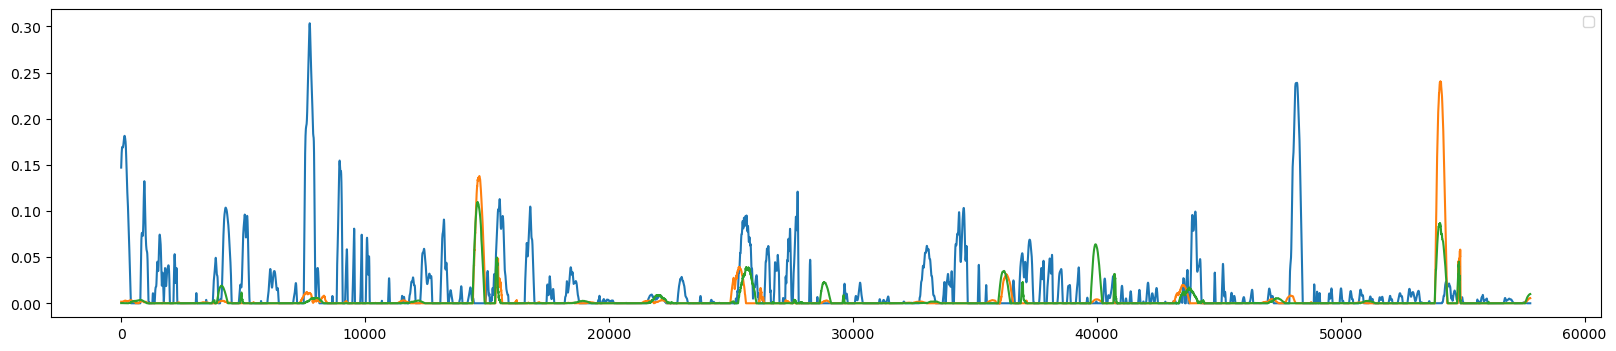

In [125]:
raws,procs,sr = do_bar_sample([100], "06 Encore A", process=get_freq_segmented_transience, ext="mp3")

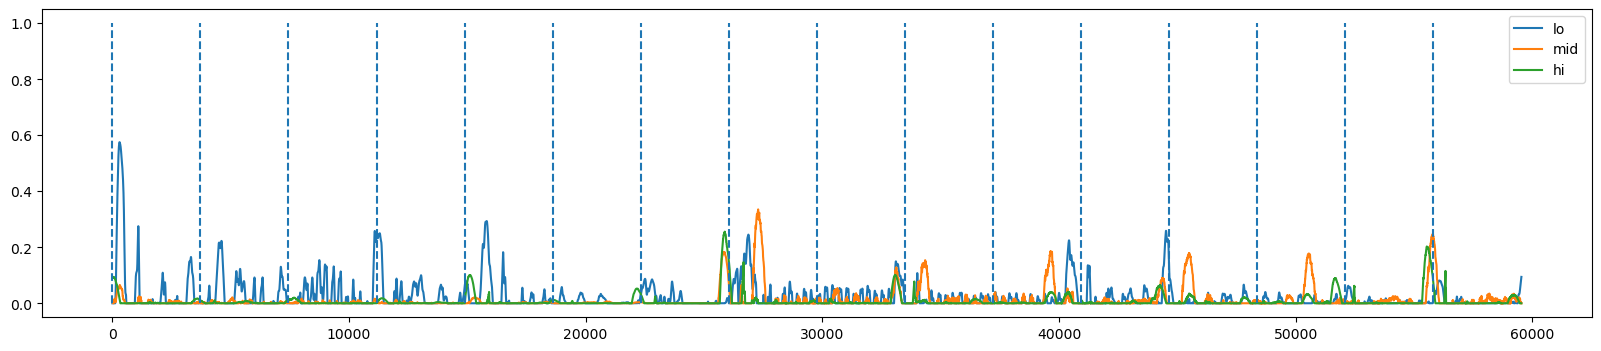

In [136]:
plot_bar_sample([81],raws,procs,sr )

In [88]:
raws[-1].shape

(29988,)

In [82]:
len(procs)

119

In [95]:
procs = get_freq_segmented_transience(samples,framerate=sr)

In [96]:
procs.shape

(6291654, 3)

In [97]:
_ = procs[:10]

In [98]:
list(map(print,_))

[7.19538019e-11 2.40945320e-21 2.02840144e-09]
[7.26546221e-11 2.41143334e-21 2.03440709e-09]
[7.33554708e-11 2.41487195e-21 2.04228083e-09]
[7.40560629e-11 2.42282544e-21 2.04958434e-09]
[7.47560781e-11 2.42550774e-21 2.05069647e-09]
[7.54551589e-11 2.41879981e-21 2.04715656e-09]
[7.61529063e-11 2.41082098e-21 2.05434419e-09]
[7.68488765e-11 2.41508051e-21 2.03557912e-09]
[7.75425773e-11 2.41673832e-21 1.97098535e-09]
[7.82334656e-11 2.40306220e-21 1.95173814e-09]


[None, None, None, None, None, None, None, None, None, None]

In [116]:
max([np.max(proc,axis=0) for proc in procs])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [119]:
np.max(np.stack([np.max(proc,axis=0) for proc in procs]), axis=0)

array([1.41528032e+01, 9.61447577e-12, 3.09225488e-01])

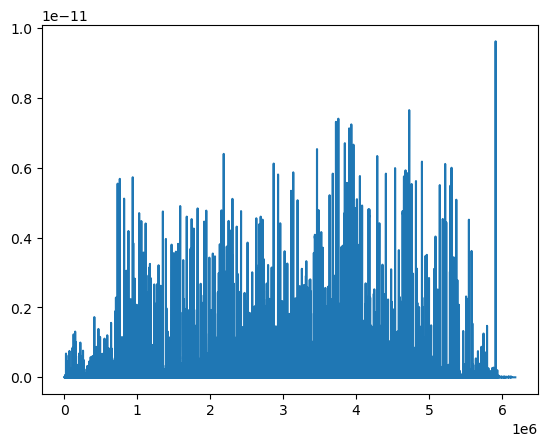

In [121]:
plt.plot(np.concatenate([proc[:,1] for proc in procs]))

In [120]:
procs

[array([[2.65416803e-01, 0.00000000e+00, 1.80338672e-03],
        [2.68110058e-01, 0.00000000e+00, 1.79439485e-03],
        [2.70863711e-01, 0.00000000e+00, 1.76189286e-03],
        ...,
        [1.12998311e-01, 1.09683413e-15, 0.00000000e+00],
        [1.09218110e-01, 1.16349547e-15, 0.00000000e+00],
        [1.05302853e-01, 1.23715450e-15, 0.00000000e+00]]),
 array([[1.01282716e-01, 1.43947477e-15, 0.00000000e+00],
        [9.71885755e-02, 1.74753723e-15, 0.00000000e+00],
        [9.30517995e-02, 2.05299839e-15, 0.00000000e+00],
        ...,
        [0.00000000e+00, 8.30259407e-15, 6.18742255e-05],
        [0.00000000e+00, 9.43048953e-15, 6.47036820e-05],
        [0.00000000e+00, 1.03995553e-14, 6.60783311e-05]]),
 array([[0.00000000e+00, 1.08821023e-14, 6.88448108e-05],
        [0.00000000e+00, 1.08235234e-14, 7.12865662e-05],
        [0.00000000e+00, 1.05320997e-14, 7.38124768e-05],
        ...,
        [0.00000000e+00, 3.12492671e-14, 0.00000000e+00],
        [0.00000000e+00, 3.16